# Milestone-2: Regression

This notebook corresponds to the second stage of the Machine Learning final project, as part of the Copernicus Master in Digital Earth, in the Data Science track at UBS by Candela Sol PELLIZA & Rajeswari PARASA.

The project is focused on properties' price prediction for the city of Ames, Iowa, Us. The present Notebook contains two parts: 
1. The first part corresponds to some updates and corrections in the preprocessing and splitting of data that was proposed in the previous stage, ending with the updated, ready-to-work training and test sets.
2. The second part corresponds to the specific tasks of regression, following the requirements of milestone 2

## PART 1: UPDATES ON PREPROCESSING STEPS FROM MILESTONE 1

The observations we got from the milestone-1 notebook, mainly regarding the splitting of data and some minor preprocessing steps, made us consider that we needed to change the way we were splitting the data into train and test. Considering that this step was performed at the very beginning of the previous notebook, with the purpose of avoiding data leakage in the preprocessing, redoing the train-test split implies also redoing the preprocessing steps.

Having this situation in mind, this first part of the notebook will present in detail the new changes we decided to include, in terms of both data splitting and preprocessing. However, for the rest of preprocessing steps, as they were already explained and justified in the previous notebook, they will be added here to include the whole workflow, but not explained again.

### 1.a. Loading libraries and importing the original dataset

In [279]:
#Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import warnings

In [280]:
#Setting pandas to show all the columns
pd.set_option('display.max_columns', None)

In [281]:
#Importing  and visualizing the dataset
data = pd.read_csv('OpenData/Ames.csv')
data.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


### 1.b. First preprocessing steps

In [282]:
#Create a dictionary with the old and new variable's names
RenameMapping = {
    'area': 'BldgArea',
    'price': 'SoldPrice',
    'MS.SubClass': 'MSSubClass',
    'MS.Zoning': 'MSZoning',
    'Lot.Frontage': 'LotFrontage',
    'Lot.Area': 'LotArea',
    'Lot.Shape': 'LotShape',
    'Land.Contour': 'LandContour',
    'Lot.Config': 'LotConfig',
    'Land.Slope': 'LandSlope',
    'Condition.1': 'Condition1',
    'Condition.2': 'Condition2',
    'Bldg.Type': 'BldgType',
    'House.Style': 'HouseStyle',
    'Overall.Qual': 'OverallQual',
    'Overall.Cond': 'OverallCond',
    'Year.Built': 'YearBuilt',
    'Year.Remod.Add': 'YearRemodAdd',
    'Roof.Style': 'RoofStyle',
    'Roof.Matl': 'RoofMatl',
    'Exterior.1st': 'Exterior1st',
    'Exterior.2nd': 'Exterior2nd',
    'Mas.Vnr.Type': 'MasVnrType',
    'Mas.Vnr.Area': 'MasVnrArea',
    'Exter.Qual': 'ExterQual',
    'Exter.Cond': 'ExterCond',
    'Bsmt.Qual': 'BsmtQual',
    'Bsmt.Cond': 'BsmtCond',
    'Bsmt.Exposure': 'BsmtExposure',
    'BsmtFin.Type.1': 'BsmtFinType1',
    'BsmtFin.SF.1': 'BsmtFinSF1',
    'BsmtFin.Type.2': 'BsmtFinType2',
    'BsmtFin.SF.2': 'BsmtFinSF2',
    'Bsmt.Unf.SF': 'BsmtUnfSF',
    'Total.Bsmt.SF': 'TotalBsmtSF',
    'Heating.QC': 'HeatingQual',
    'Central.Air': 'CentralAir',
    '1st.Flr.SF': '1stFlrSF',
    '2nd.Flr.SF': '2ndFlrSF',
    'Low.Qual.Fin.SF': 'LowQualFinSF',
    'Bsmt.Full.Bath': 'BsmtFullBath',
    'Bsmt.Half.Bath': 'BsmtHalfBath',
    'Full.Bath': 'FullBath',
    'Half.Bath': 'HalfBath',
    'Kitchen.Qual': 'KitchenQual',
    'TotRms.AbvGrd': 'TotRmsAbvGrd',
    'Fireplaces': 'Fireplaces',
    'Fireplace.Qu': 'FireplaceQu',
    'Garage.Type': 'GarageType',
    'Garage.Yr.Blt': 'GarageYrBlt',
    'Garage.Finish': 'GarageFinish',
    'Garage.Cars': 'GarageCars',
    'Garage.Area': 'GarageArea',
    'Garage.Qual': 'GarageQual',
    'Garage.Cond': 'GarageCond',
    'Paved.Drive': 'PavedDrive',
    'Wood.Deck.SF': 'WoodDeckSF',
    'Open.Porch.SF': 'OpenPorchSF',
    'Enclosed.Porch': 'EnclosedPorchSF',
    '3Ssn.Porch': '3SsnPorchSF',
    'Screen.Porch': 'ScreenPorchSF',
    'Pool.Area': 'PoolArea',
    'Pool.QC': 'PoolQual',
    'Misc.Feature': 'MiscFeature',
    'Misc.Val': 'MiscVal',
    'Mo.Sold': 'MoSold',
    'Yr.Sold': 'YrSold',
    'Sale.Type': 'SaleType', 
    'Sale.Condition': 'SaleCondition',
    'X1st.Flr.SF': 'X1FloorSF',
    'X2nd.Flr.SF': 'X2FloorSF',
    'X3Ssn.Porch': '3SsnPorchSF',
    'Kitchen.AbvGr': 'KitchenAbvGr',
    'Bedroom.AbvGr': 'BedroomAbvGr',
    }

#Applying the name change
data.rename(columns=RenameMapping, inplace=True)

#Dropping 'Order' column
data = data.drop('Order', axis=1)

### 1.c. Data Split into Train and Test

After reviewing the train & test data split performed in milestone 1, we realised that the unbalanced spatial distribution of samples had not been taken into account properly. The spatial attribute of our data is given by the "neighborhood" variable.
The barplot below shows the amount of samples belonging to each neighborhood in the original dataset.

<Axes: xlabel='Neighborhood'>

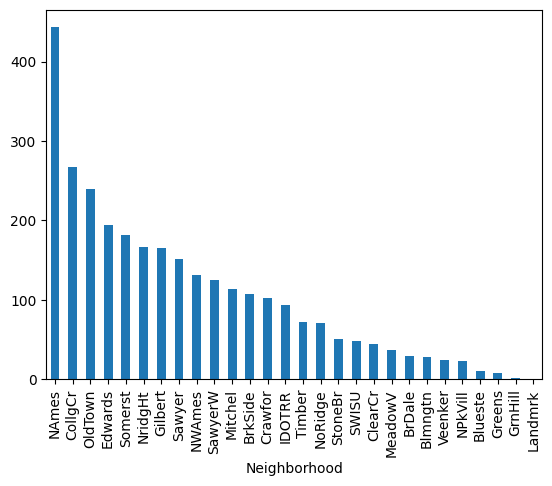

In [283]:
data['Neighborhood'].value_counts().plot(kind='bar')

The barplot gives meaningful information about two things. The first one is that the neighborhoods "GrnHill" and "Landmrk" have very few samples (1 and 2 respectively). The second one is that the neighborhoods' samples distribution is clearly unbalanced.

To solve the first issue, the rows corresponding to the mentioned neighborhoods will be dropped, given that such a small number can not be representative.

In [284]:
# Counting the number of samples
landmrk_smp = len(data[data['Neighborhood'] == 'Landmrk'])
print(f'Landmrk samples: {landmrk_smp}')

GrnHill_smp = len(data[data['Neighborhood'] == 'GrnHill'])
print(f'GrnHill samples: {GrnHill_smp}')

Landmrk samples: 1
GrnHill samples: 2


In [285]:
# Dropping the lines for Landmrk and GrnHill neighborhoods
neighb_todrop = ['Landmrk', 'GrnHill']
data = data[~data['Neighborhood'].isin(neighb_todrop)]

The next step is to handle the unbalanced neighborhoods' samples sdistribution. Considering that location is a key aspect on defining the price of a property, and taking into account the spatial autocorrelation effect, it is crucial to have a balanced distribution of samples from the different neighborhoods in our training and test datasets. This is specially important for the generalization of the model to unseen data, and also to take into account the influence of the spatial aspect.

When checking how the random split used in the previous notebook was handling this issue, we realised that the distribution was not balanced, specially for the classes with few samples. This can be confirmed in the graph below, which shows the neighborhood samples distribution in training and test dataset for the random technique previously adopted

In [286]:
#Divide data into train and test following the previously adopted technique
data_train_prev, data_test_prev = train_test_split(data, test_size=0.2, random_state=33)

# We use test_size =0.2 to indicate 20% of the data is used for testing and 80% for training
# We use random_state = 33 to ensure that the same random split is reproduced every time

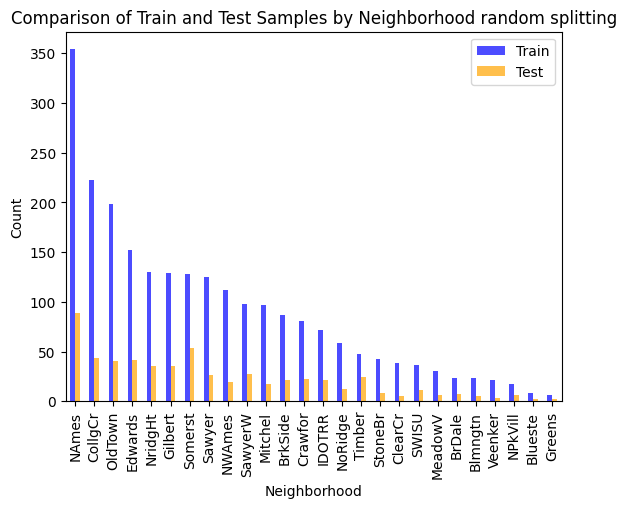

----------Proportions of samples from neighborhoods---------
   Neighborhood  train_prop %  test_prop %
0         NAmes          15.1         15.2
1       CollgCr           9.5          7.5
2       OldTown           8.5          7.0
3       Edwards           6.5          7.2
4       NridgHt           5.6          6.1
5       Gilbert           5.5          6.1
6       Somerst           5.5          9.2
7        Sawyer           5.3          4.4
8        NWAmes           4.8          3.2
9       SawyerW           4.2          4.6
10      Mitchel           4.1          2.9
11      BrkSide           3.7          3.6
12      Crawfor           3.5          3.8
13       IDOTRR           3.1          3.6
14      NoRidge           2.5          2.0
15       Timber           2.1          4.1
16      StoneBr           1.8          1.4
17      ClearCr           1.7          0.9
18        SWISU           1.6          1.9
19      MeadowV           1.3          1.0
20       BrDale           1.0       

In [287]:
# Function to plot double bar graphs to compare the distribution of neighborhoods in train and test sets
def samples_neighb(data_train, data_test, technique):
    # Count samples by neighborhood in train and test sets
    train_counts = data_train['Neighborhood'].value_counts().reset_index()
    test_counts = data_test['Neighborhood'].value_counts().reset_index()

    # Merge the counts based on the 'Neighborhood' column
    combined_counts = pd.merge(train_counts, test_counts, on='Neighborhood', how='outer')

    # Plot
    ax=combined_counts.plot(x='Neighborhood', kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.title(f'Comparison of Train and Test Samples by Neighborhood {technique} splitting')
    plt.legend(["Train", "Test"])
    plt.show()

    # Propotions as percentages
    combined_counts['train_prop %'] = round(combined_counts['count_x'] *100/ combined_counts['count_x'].sum(),1)
    combined_counts['test_prop %'] = round(combined_counts['count_y']*100 / combined_counts['count_y'].sum(),1)
    print('----------Proportions of samples from neighborhoods---------')
    print(combined_counts[['Neighborhood', 'train_prop %', 'test_prop %']])


samples_neighb(data_train_prev, data_test_prev, technique='random')

To guarantee a balanced distribution of neighborhoods' samples between training and test datasets, we will perform an stratified split for the neighborhood variable, by means of the "stratify" parameter in the scikitlearn train_test_split() function.

In [288]:
# Divide data into train and test with stratified split
data_train, data_test= train_test_split(data, test_size=0.2, random_state=33, stratify=data['Neighborhood'])

The plot below shows the distribution of neighborhoods' samples in training and test data after the stratified split, with a proportional amount of samples for each neighborhood.

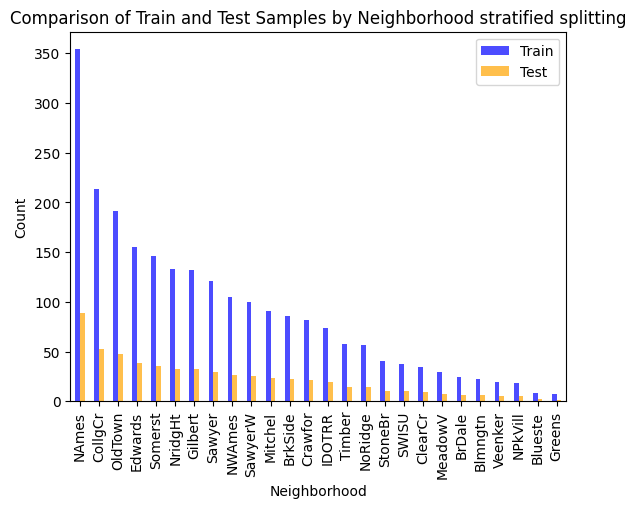

----------Proportions of samples from neighborhoods---------
   Neighborhood  train_prop %  test_prop %
0         NAmes          15.1         15.2
1       CollgCr           9.1          9.0
2       OldTown           8.2          8.2
3       Edwards           6.6          6.7
4       Somerst           6.2          6.1
5       NridgHt           5.7          5.6
6       Gilbert           5.6          5.6
7        Sawyer           5.2          5.1
8        NWAmes           4.5          4.4
9       SawyerW           4.3          4.3
10      Mitchel           3.9          3.9
11      BrkSide           3.7          3.8
12      Crawfor           3.5          3.6
13       IDOTRR           3.2          3.2
14       Timber           2.5          2.4
15      NoRidge           2.4          2.4
16      StoneBr           1.8          1.7
17        SWISU           1.6          1.7
18      ClearCr           1.5          1.5
19      MeadowV           1.3          1.2
20       BrDale           1.0       

In [289]:
samples_neighb(data_train, data_test, technique='stratified')

### 1.d. Post data-splitting Preprocessing

The following blocks of code contain all the preprocessing steps that the dataset requires, such as variables encoding and NA values handling, which were described in detail in the Milestone-1 notebook. For more information on the reasons, steps and parameters, refer to this notebook [## COMPLETE]

#### 1.d.1. Variables Encoding

In [290]:
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQual', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQual', 'Fence', 'PavedDrive' ]
binary = ['Street', 'CentralAir']
nominal = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
other = ['Alley']

Encoding Ordinal variables

In [291]:
# Mapping dictionary
variable_mappings = {
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'HeatingQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Na': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2}
}

# List of columns to map
columns_to_map = variable_mappings.keys()

def apply_mappings(data):
    for column in columns_to_map:
        data[column] = data[column].map(variable_mappings[column])

# Applying changes to training dataset
apply_mappings(data_train)

# Applying changes to test dataset
apply_mappings(data_test)

In [292]:
# Iterate through the columns in the 'ordinal' list and fill NA values with 0

#Applying changes to training dataset
for column in ordinal:
    data_train[column].fillna(0, inplace=True)

#Applying changes to test dataset
for column in ordinal:
    data_test[column].fillna(0, inplace=True)

Encoding binary variables

In [293]:
#Convert binary variables into numerical

Street = {'Grvl': 0, 'Pave': 1}
CentralAir = {'N': 0, 'Y': 1}

#Applying changes to training dataset
data_train['Street'] = data_train['Street'].map(Street)
data_train['CentralAir'] = data_train['CentralAir'].map(CentralAir)

#Applying changes to test dataset

data_test['Street'] = data_test['Street'].map(Street)
data_test['CentralAir'] = data_test['CentralAir'].map(CentralAir)

In [294]:
#Encode
Alley = {'Grvl': 1, 'Pave': 1, 'NA': 0}

#Applying changes to training dataset

data_train['Alley'] = data_train['Alley'].map(Alley)

#Fill NA
data_train['Alley'].fillna(0, inplace=True)

#Applying changes to test dataset

data_test['Alley'] = data_test['Alley'].map(Alley)

#Fill NA
data_test['Alley'].fillna(0, inplace=True)

#### 1.d.2. Handling NA Values

In [295]:
#Filling NAs on training
data_train['MiscFeature'].fillna('None', inplace=True)
data_train['GarageType'].fillna('None', inplace=True)

#Filling NAs on test
data_test['MiscFeature'].fillna('None', inplace=True)
data_test['GarageType'].fillna('None', inplace=True)

In [296]:
# Drop rows with NaN values in specific columns in training
columns_to_check = ['MasVnrType' , 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'Electrical', 'GarageArea']
data_train.dropna(subset=columns_to_check, inplace=True)

# Drop rows with NaN values in specific columns in test
data_test.dropna(subset=columns_to_check, inplace=True)

In [297]:
## LotFrontage VARIABLE

#Fill Na values with column mean - training
mean_LotFrontage_train = data_train['LotFrontage'].mean()
data_train['LotFrontage'].fillna(mean_LotFrontage_train, inplace=True)

#Fill Na values with column mean - test
mean_LotFrontage_test = data_test['LotFrontage'].mean()
data_test['LotFrontage'].fillna(mean_LotFrontage_test, inplace=True)

In [298]:
## GarageYrBlt VARIABLE

#Filling GarageYrBlt NA values with YearBuilt in training
data_train['GarageYrBlt'].fillna(data_train['YearBuilt'], inplace=True)

#Filling GarageYrBlt NA values with YearBuilt in test
data_test['GarageYrBlt'].fillna(data_test['YearBuilt'], inplace=True)


#### 1.d.3. Encoding Categorical Variables

In [299]:
# Perform one-hot encoding (returns True/False values) in training
data_train = pd.get_dummies(data_train, columns=nominal, prefix=nominal, dtype=int)

# Perform one-hot encoding (returns True/False values) in test
data_test = pd.get_dummies(data_test, columns=nominal, prefix=nominal, dtype=int)

### 1.e. Columns dropping

In the previous milestone, we observed that, the correlation matrix has two rows with `nan` values for all cells. Upon inspection of the corresponding features, we realised that the issue was cause because the columns had same value for all samples (because of being columns deried from onehot encoding). This columns are insignificant for the analysis, so we decide to drop them from both the training and test datasets.

In [300]:
# List of colunmns with only 1 value for all rows in test
def singlevalue_columns(data):
    # Create a list of single-valued columns
    singlevalue_cols = []
    for i in data.columns:
        if data[i].nunique() <2:
            singlevalue_cols.append(i)
    #print(f'Columns with only 1 value: {singlevalue_cols}')
    return singlevalue_cols

drop_cols = singlevalue_columns(data_train)
print(drop_cols)

['LowQualFinSF']


In [301]:
# Dropping columns in train dataset
data_train.drop(drop_cols, axis=1, inplace=True)

# Dropping columns in test dataset
data_test.drop(drop_cols, axis=1, inplace=True)

### 1.f. Treatment for missing columns between train and test

We are finished with column preprocessing at this stage for both train and test datasets. Since preprocessing is carried out separately for train and test datasets, we need to check if the number of columns match. This is important for being able to apply our train model to the test dataset afterwards.


In [302]:
data_train.shape

(923, 204)

In [303]:
data_test.shape

(231, 185)

In [304]:
# Columns from test dataset not present in train dataset
test_cols_drop = [col for col in data_test.columns if col not in data_train.columns]
print(len(test_cols_drop), ' features from test data do not appear in train data')
print('These are ', test_cols_drop)

7  features from test data do not appear in train data
These are  ['Condition2_RRAn', 'RoofMatl_ClyTile', 'Heating_Wall', 'MiscFeature_Othr', 'MiscFeature_TenC', 'SaleType_Con', 'SaleType_ConLw']


In [305]:
# Columns from train dataset not present in test dataset
train_cols_add = [col for col in data_train.columns if col not in data_test.columns]
print(len(train_cols_add), ' features from train data do not appear in test data')
print('These are ', train_cols_add)

26  features from train data do not appear in test data
These are  ['MSSubClass_70', 'MSSubClass_75', 'MSSubClass_190', 'LotConfig_FR3', 'Neighborhood_MeadowV', 'Condition1_RRAe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 'HouseStyle_2.5Unf', 'RoofStyle_Gambrel', 'RoofStyle_Shed', 'RoofMatl_Roll', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'MasVnrType_CBlock', 'Foundation_Wood', 'MiscFeature_Elev', 'SaleType_ConLI', 'SaleType_Oth', 'SaleType_VWD', 'SaleCondition_AdjLand']


We can see that the columns in the dataset are not matching, having each dataset some columns that are no present on the other one. Following a procedure that avoids data leakage, we need to consider as valid all, and only, the columns that are present in our train dataset after the preprocessing. 

This means that we will perform a two step procedure:

The columns that are present in the test dataset but not in the train set will be eliminated from the test set. This is beause the test set is considered as unseen data, for which we shouldnt have knowledge about this other variables existence.

For the columns that are present in the training dataset but not in the test one, we will recreate them in the test dataset, at the same position, filling all the rows with zeros. The addition of these columns will be neutral in affecting the test dataset, but will make it easier for handling numpy arrays with the same dimensions.

In [306]:
# Treatment for missing columns:

# A) For columns missing in train data, drop them from test data. 
data_test.drop(test_cols_drop, axis=1, inplace=True)

# B) For columns missing in test data, add them to test data and fill them with 0s.
for c in train_cols_add:
    data_test[c] = 0

data_test = data_test[data_train.columns]

print(data_test.shape)

(231, 204)


In [307]:
data_train.shape

(923, 204)

The columns in both train and test datasets, now match. We are now ready to export them to csv files for further analysis in the next milestone.

### 1.g. Processed datasets exporting
After processing both training and test datasets, we export them as csv files. It is improtant to notice that the normalization step that will be performed later should also be done for the testing set when running the models.


In [308]:
# Exporting training datset
data_train.to_csv('OpenData/ames_train_clean.csv', index=False)

# Exporting test datset
data_test.to_csv('OpenData/ames_test_clean.csv', index=False)

### 1.h. Target Variable Distribution, Outliers and Evaluation Metric

During the exploatory analysis of the data performed in the previous notebok, we identify two main issues in the distribution of our data:

1- **The target variable is right skewed and not normally distributed. This can be seen in the histogram plot and the QQ plot below.**

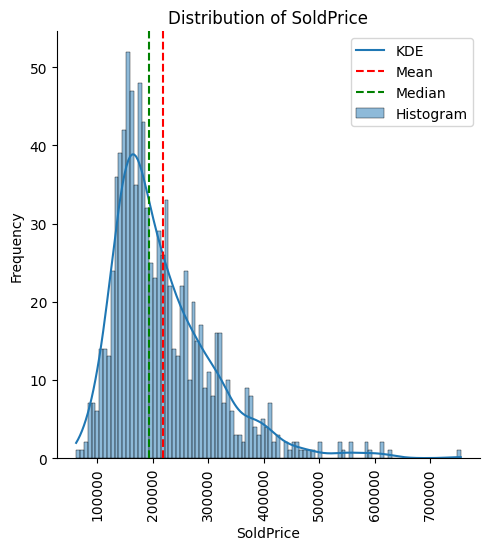 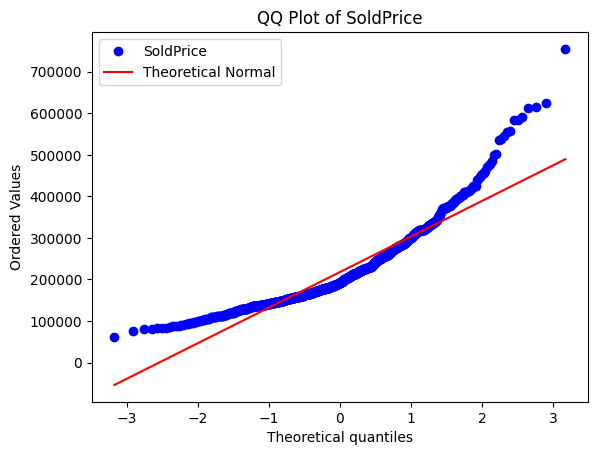

2- **There are outliers in the data (as can be seen in the graph below plotted between SoldPrice and BldgArea.)** 

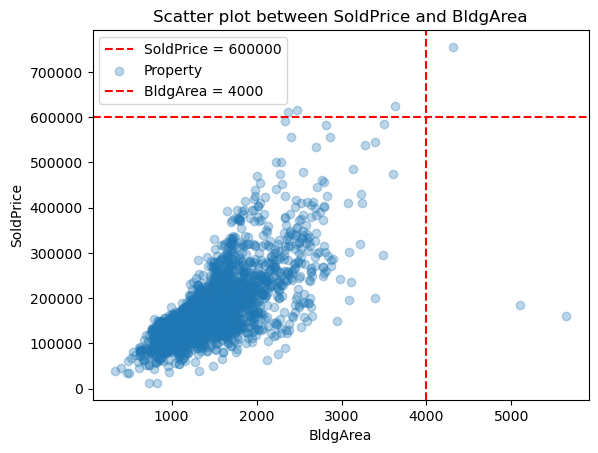

Due to these characteristics, we discussed in the previous notebook the possbility of log transforming the data, and eliminating the outliers, for obtaining a normally distributed dataset. However, after reconciling our observations from the EDA and the feedback received from the mentors, we realised that doing these steps were redundant with the proposition of Root Mean Squared Logarithic Error (RMSLE) as the main metric.

Based on literature that we encountered on the RMSLE metric, is robust to outliers ([Saxena, 2019](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a); [Sagi, 2023](https://help.pecan.ai/en/articles/6456388-model-performance-metrics-for-regression-models#Modelperformancemetricsforregressionmodels-RootMeanSquaredLogarithmicError(RMSLE))) and is suitable for non-normally distributed or skewed data [(Hussain, 2022)](https://techwithshadab.medium.com/root-mean-squared-error-root-mean-squared-logarithmic-error-70e645efcccb). This is because RMSLE measures the relative distance of the predicted value from the actual value, unlike RMSE which measures the absolute distance. Due to this, RMSE can be heavily affected by the outliers, the range of the target variable and the distribution of the target variable.

Following this criteria, the dataset will be kept without dropping any outlier or applying log transformation, considering these characteristics when measuring the model accuracy with RMSLE.

Moreover, we will keep taking into account the other two auxiliary metrics previously defined:

- RSME given that it provides a good measure of how far the predicted values are from the groundtruth values, providing the error value in the same unit scale as the target variable. Being our prediction in a currency unit, this allows an easy interpretability of the results. 

- R2 in order to allow for a standardised comparison. It gives a measure of how much of the variance in the data is explained by the model, and allows comparing the results with other models in a range from 0-1. 

## 2. MILESTONE 2: REGRESSION

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.linear_model import ElasticNet
from math import sqrt
import warnings

### 2.a. Importing data and transforming to Numpy Array

In [2]:
# Import train and test datasets in csv format
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')

In [3]:
data_train.shape

(923, 204)

In [4]:
data_test.shape

(231, 204)

After importing the datasets in csv format, we transform them to numpy array format. We will also store the names of the columns in a separate vector

In [5]:
# Creating numpy arrays for X and Y
X_train = data_train.drop(columns = ['PID', 'SoldPrice']).values
X_test = data_test.drop(columns = ['PID', 'SoldPrice']).values
X_names = data_train.drop(columns = ['PID', 'SoldPrice']).columns.tolist()

Y_train = data_train['SoldPrice'].values.reshape(-1,1)
Y_test = data_test['SoldPrice'].values.reshape(-1,1)

In [6]:
print(X_names)

['BldgArea', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQual', 'CentralAir', 'X1FloorSF', 'X2FloorSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorchSF', '3SsnPorchSF', 'ScreenPorchSF', 'PoolArea', 'PoolQual', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubCl

In [7]:
X_train

array([[2.5190e+03, 4.2000e+01, 2.6178e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.7280e+03, 9.8000e+01, 1.3260e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0980e+03, 7.4000e+01, 7.3900e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [2.3380e+03, 5.2000e+01, 5.1974e+04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.0730e+03, 7.4000e+01, 9.9810e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.8140e+03, 7.4000e+01, 9.7710e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [8]:
X_test

array([[1.52400000e+03, 7.59562842e+01, 2.99800000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.02000000e+03, 9.40000000e+01, 1.22200000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.96000000e+03, 9.50000000e+01, 1.36180000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.49400000e+03, 3.90000000e+01, 1.54100000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.19800000e+03, 8.40000000e+01, 1.42600000e+04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.72600000e+03, 7.90000000e+01, 9.41600000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [317]:
Y_train

array([[335000],
       [ 84900],
       [135000],
       [110000],
       [159900],
       [230000],
       [145000],
       [188000],
       [300000],
       [113500],
       [294900],
       [209500],
       [341000],
       [279000],
       [394617],
       [184900],
       [535000],
       [237000],
       [133000],
       [192500],
       [144500],
       [140000],
       [148000],
       [225000],
       [173000],
       [190000],
       [100000],
       [160000],
       [203135],
       [409900],
       [392000],
       [195000],
       [250000],
       [293000],
       [248900],
       [124500],
       [206000],
       [312500],
       [245000],
       [226500],
       [229000],
       [120000],
       [221000],
       [187500],
       [293077],
       [143000],
       [221800],
       [378000],
       [152000],
       [339750],
       [145500],
       [147000],
       [215000],
       [145500],
       [258000],
       [132000],
       [177000],
       [611657],
       [285000

In [318]:
Y_test

array([[166000],
       [402861],
       [320000],
       [441929],
       [149500],
       [156820],
       [ 99000],
       [167900],
       [297900],
       [582933],
       [317500],
       [300000],
       [302000],
       [226000],
       [170000],
       [305000],
       [108538],
       [125000],
       [425000],
       [120000],
       [320000],
       [335000],
       [282000],
       [ 96000],
       [377426],
       [325624],
       [274900],
       [159500],
       [100500],
       [215000],
       [188500],
       [136000],
       [144000],
       [264500],
       [395192],
       [167900],
       [337000],
       [252000],
       [153000],
       [234000],
       [274000],
       [260000],
       [144000],
       [197000],
       [190000],
       [137900],
       [246500],
       [282500],
       [137000],
       [245000],
       [300000],
       [110000],
       [ 87500],
       [223000],
       [149900],
       [160000],
       [230500],
       [412083],
       [424870

### 2.b. Standardization
As we concluded in the visual analysis from the previous notebook, the variables have different scales. This can be a problem for linear regression, as the variables with higher scale will have a higher impact on the model. To avoid this problem, we will standardize the variables. This will bring all the variables to the same scale, and hence the variables will have equal impact on the model.

For this purpose, we use the sckit function StandardScaler(). It is important to notice that this function includes a statement for authomatic handling the standardisation of variables with standard deviation = 0, replacing the std for 1. This is important given the fact that, as we added 0 columns in the test dataset, if we dont handle this issue, it would throw an error. 

In [9]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Stack ones to X matrices to account for the intercept
X_train = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test))

In [10]:
X_train

array([[ 1.        ,  1.62061741, -1.48895632, ..., -0.11952286,
         0.49220027, -0.37538608],
       [ 1.        ,  0.11620038,  1.11671724, ..., -0.11952286,
        -2.03169333, -0.37538608],
       [ 1.        , -1.08200787,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608],
       ...,
       [ 1.        ,  1.27637028, -1.02365747, ..., -0.11952286,
        -2.03169333,  2.66392403],
       [ 1.        , -1.12955582,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608],
       [ 1.        ,  2.18168318,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608]])

In [11]:
X_test

array([[ 1.00000000e+00, -2.40384636e-01, -5.48281015e-16, ...,
        -9.34538627e-02,  5.52344771e-01, -4.50693909e-01],
       [ 1.00000000e+00,  6.82831603e-01,  6.96159874e-01, ...,
        -9.34538627e-02, -1.81046342e+00,  2.21880078e+00],
       [ 1.00000000e+00,  5.71152219e-01,  7.34741721e-01, ...,
        -9.34538627e-02, -1.81046342e+00,  2.21880078e+00],
       ...,
       [ 1.00000000e+00, -2.96224328e-01, -1.42584168e+00, ...,
        -9.34538627e-02, -1.81046342e+00, -4.50693909e-01],
       [ 1.00000000e+00,  1.01414711e+00,  3.10341410e-01, ...,
        -9.34538627e-02,  5.52344771e-01, -4.50693909e-01],
       [ 1.00000000e+00,  1.35602623e-01,  1.17432177e-01, ...,
        -9.34538627e-02, -1.81046342e+00,  2.21880078e+00]])

### 2.c. Basic Regression model: Multiple Linear Regression

Based on the exploratory data analysis performed in the previous milestone, we will begin with fitting Multiple Linear Regression model (MLR) to our data and understand its performance. Since we observe notable values for Pearson's correlation coefficient between the target variable and the features, we expect the multivariate linear regression model to be a good model to start with for establishing a multivariate relationship between the them. 

However, we do bear in mind that a linear regression model is sensitive to outliers and skewness of the target variable (which have not been treated with log transformation currently). 

We start by defining functions for calculating the selected metrics:

In [12]:
# Function for calculating RMSLE
def rmsle(y_test, y_pred):
    """
    This function calculates the RMSLE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values
    
    Returns:
    float: RMSLE value
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))
# Define RMSLE as a metric for cross_validate
rmsle_scorer = make_scorer(rmsle)

# Define a custom scorer for R2
r2_scorer = make_scorer(r2_score)

# Function for calculating RMSE
def rmse(y_test, y_pred):
    """
    This function calculates the RMSE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values

    Returns:
    float: RMSE value
    """
    
    return np.sqrt(mean_squared_error(y_test, y_pred))
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(rmse)

After, we define functions for printing the graphics and errors results when testing the models:

In [13]:
# Define functions for printing model's predictions and scores
def plot_Yt_Yp(y_test, y_pred, set_limit=None):
    """
    Plots the actual vs predicted values
    ------------------------------------
    Parameters:
    y_test: actual values
    y_pred: predicted values

    Returns:
    None
    """
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Actual Sold Price')
    plt.ylabel('Predicted Sold Price')
    plt.title('Actual vs Predicted Sold Price')
    # Set axis limits if set_limit parameter is provided
    if set_limit:
        plt.axis(set_limit)

    plt.show()

def print_eval_metrics(y_test,y_pred):

    """
    Prints the evaluation metrics
    -----------------------------
    Parameters:
    y_test: actual values
    y_pred: predicted values

    Returns:
    None
    """
    try:
        # try block to catch errors in case -ve log computations are attempted
        print('RMSLE:', rmsle(y_test, y_pred))
    except:
        print('RMSLE: cannot be calculated')

    print('R2:', r2_score(y_test, y_pred))

    print('RMSE:', rmse(y_test, y_pred))


#### 2.c.1. MLR performance on training data - considering whole train data

The first approach consists on training the model on the training dataset, and asses the prediction performance over the same data. For this purpose we use the LinearRegression() function from ScikitLearn.

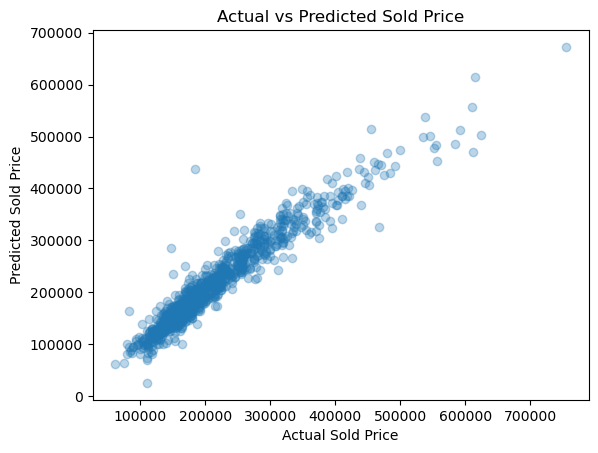

RMSLE: 0.12249839920392153
R2: 0.9233243646278082
RMSE: 25516.153213144


In [14]:
# Calculate simple regression model on the whole training data and evaluate on training data
basic_mlr = LinearRegression().fit(X_train, Y_train)
Y_pred = basic_mlr.predict(X_train)
plot_Yt_Yp(Y_train, Y_pred)
print_eval_metrics(Y_train, Y_pred)

We can observe that the fitting of the model for the training data is really good (RMSLE = 0.1, R2 = 0.92). However, this is not a good metric for the model, considering that we are evaluating the prediction performance for dataset that was used for training the model. We now need to evaluate the generalization ability of the model on unseen data.

#### 2.c.2. MLR performance on training data - considering 5-fold cross validation
A second approach, still using only the training data, is testing the model using cross validation. In this case, we are setting the fold splits to 5 (a standard common partition). The objective is to analyze how he model is performing when testing on unseen validation data inside the training dataset. 

For this purpose, we use the cross_validate function from SciKitLearn. In a first attempt, we try to analyze the three metrics previously defined. Hwever, when trying to calculate the RMSLE we get an error (check the commented scoring = {} line). The reason of this will be further analyzed, but for now we will keep the R2 and RMSE metrics for this case.

In [23]:
# Uncomment the line below for checking RMSLE error
scoring = {'R2': r2_scorer, 'RMSE': rmse_scorer, 'RMSLE': rmsle_scorer}
#scoring = {'R2': r2_scorer, 'RMSE': rmse_scorer}

# Calculate model accuracy using crossval
# fix the splits for cross validation: shuffle = True because random_state is set, otherwise error is thrown
kf = KFold(n_splits=5, random_state=33, shuffle=True)

warnings.filterwarnings('ignore')
cv_results = cross_validate(basic_mlr, X_train, Y_train, scoring= scoring, cv=kf)
print(cv_results)

print('Mean RMSE', np.mean(cv_results['test_RMSE']))
print('Mean R2', np.mean(cv_results['test_R2']))

try:
    print('Mean RMSLE:', np.mean(cv_results['test_RMSLE']))
except:
    print('Mean RMSLE: cannot be calculated')

{'fit_time': array([0.01962805, 0.02298546, 0.01777816, 0.0212822 , 0.00868583]), 'score_time': array([0.        , 0.0056119 , 0.        , 0.00441432, 0.        ]), 'test_R2': array([-1.78895328e+23, -1.47165704e+23, -5.89798934e+22, -5.95968983e+21,
       -1.39060853e+23]), 'test_RMSE': array([3.75804629e+16, 3.31390879e+16, 2.23828720e+16, 6.86436124e+15,
       3.83671495e+16]), 'test_RMSLE': array([nan, nan, nan, nan, nan])}
Mean RMSE 2.7666786674552948e+16
Mean R2 -1.0601229382632711e+23
Mean RMSLE: nan


**Observations and conclusions:**
- RMSE is very large (+ve infinity)
- R2 score is very low (-ve infinity) 
- RMSLE cannot be generated (as seen as 'nan')- because the model is predicting negative values for the target value, and consequently it is mathematically not possible to get the Root Mean Squared Logarithic Error.

Furthermore, as we saw in earlier step, a very high R2 score (0.92) is observed when the model is tested on the training data itself. All of these observations, confirm that the **model is overfitting** on the training data and is highly complex.

### 2.d. Adding a Regularization Term - ElasticNet Model
The previous results of the MLR (sections 2.c.1 and 2.c.2) justify the inclusion of a regularisation term. Between the existing options, Ridge, Lasso and Elasticnet, we consider Elasticnet as the most appropriate option for our case, given that it combines the benefits from both Ridge and Lasso. This will be able to solve two important problems of our model:

1. Our model is clearly overfitting, is complex, and considering too many variables. The EDA performed at the first stage showed that the dataset has many variables with really low correlation values with the target variable. Lasso can force less a coefficient of 0 on less important terms, allowing an automatic feature selection.

2. The EDA also exposed that a lot of explanatory variables are higly correlated among them. Ridge technique obliges less important terms to take values closer to zero (and not exactly 0), minimizing their influence on the model, and grouping correlated varibales to share the weights. 

With the inclusion of an Elasticnet regression, we can address both issues at the same time, expecting a better model performance.

#### 2.d.1. Tuning EasticNet regularization hyperparameter

Given that test data is unseen, we cannot use it to finetune our regularisation hyperparameter. So we rely on cross validation scores to choose the best regularisation hyperparameter. We will use 5-fold cross validation.

`ElasticNet()` function from ScikitLearn is used to fit the model. The function uses the parameter `alpha` as the regularisation hyperparameter to initiate an ElasticNet regressor. By default, the function uses `l1_ratio` = `0.5`, which means that the penalty is equally distributed between Lasso (L1) and Ridge (L2) regularisation strategies. We will use the `cross_val_score` function from SciKitLearn to perform cross validation and obtain cross validation scores for each fold. We will use the mean of the cross validation scores to choose the best regularisation hyperparameter.
The scoring metric is specified in the crossval score, establishing rmsle, which was selected as our main metric.

Minimum RMSLE 0.14334777037026797 
Alpha value at minimum RMSLE (from alphas tested) 3.0


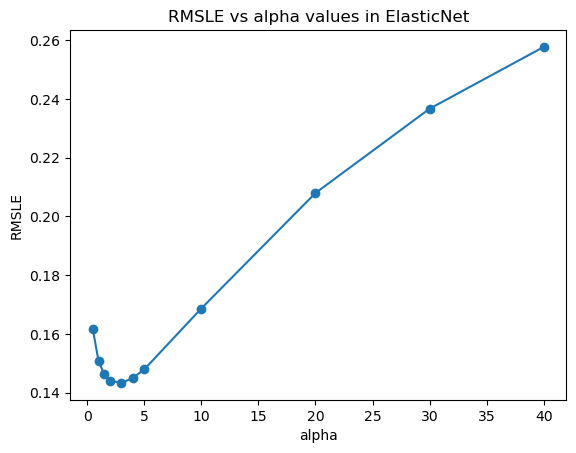

In [21]:
# Since alpha is a positive value, we need to test a range of positive values to find the optimal one
alpha_elast = [1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
mean_cv = []
# kfolds: remember that the variable 'kf' is already defined above

for i in alpha_elast:
    # Set up each model with a different alpha value iteratively
    warnings.filterwarnings('ignore') #ignore warnings
    elasticnet_mlr = ElasticNet(alpha= i).fit(X_train, Y_train)

    # Perform cross validation on the same splits each time
    cv_scores = cross_val_score(elasticnet_mlr, X_train, Y_train, cv=kf, scoring=rmsle_scorer)
    
    mean_cv.append(np.mean(cv_scores))
    

# drop entries with mean_cv = nan. This is necessary to print non-nan minimum value for mean score
dict = {'alpha': alpha_elast, 'mean_cv': mean_cv}
df = pd.DataFrame(dict).dropna()
alpha_elast = df['alpha'].tolist()
mean_cv = df['mean_cv'].tolist()
# print(alpha_elast,mean_cv)

print('Minimum RMSLE', min(mean_cv), '\n'
      'Alpha value at minimum RMSLE (from alphas tested)', alpha_elast[mean_cv.index(min(mean_cv))])
plt.plot(alpha_elast, mean_cv)
plt.scatter(alpha_elast, mean_cv)
plt.xlabel('alpha')
plt.ylabel('RMSLE')
plt.title('RMSLE vs alpha values in ElasticNet')
plt.show() 

As seen from the text and graph outputs above, highest average cross validation score is obtained for alpha in the range of 2 to 3, from the list of alphas that we tested. To get a better approximation, we can zoom into a range of 2 and 3.

Minimum RMSLE 0.14 
Alpha value at minimum RMSLE (from alphas tested) 2.67


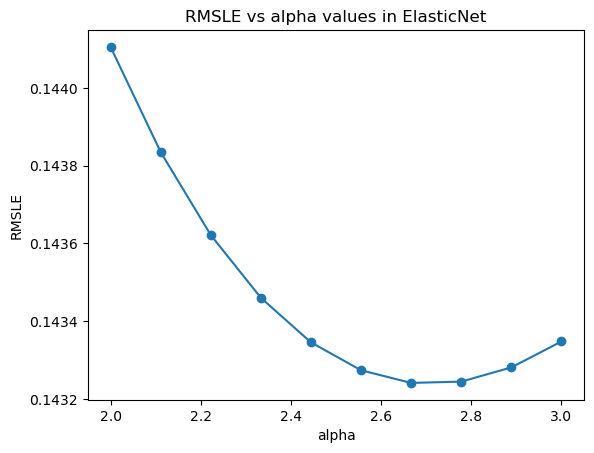

In [22]:
alpha_elast = np.linspace(2, 3, 10, endpoint=True)
mean_cv = []

for i in alpha_elast:
    # Set up each model. 
    warnings.filterwarnings('ignore') #ignore warnings
    elasticnet_mlr = ElasticNet(alpha= i).fit(X_train, Y_train)
    
    # Perform cross validation on the same splits each time
    cv_scores = cross_val_score(elasticnet_mlr, X_train, Y_train, cv=kf, scoring=rmsle_scorer)
    mean_cv.append(np.mean(cv_scores))
    min_cv = round(min(mean_cv), 2)
    alpha_min_cv = round(alpha_elast[mean_cv.index(min(mean_cv))], 2)

print('Minimum RMSLE', min_cv, '\n'
      'Alpha value at minimum RMSLE (from alphas tested)', alpha_min_cv)
plt.plot(alpha_elast, mean_cv)
plt.scatter(alpha_elast, mean_cv)
plt.xlabel('alpha')
plt.ylabel('RMSLE')
plt.title('RMSLE vs alpha values in ElasticNet')
plt.show()

The new alpha where the RMSLE is minimum is `2.67`, so we decide to take 2.67 as the alpha value for our ElasticNet model. 

#### 2.d.2. Training and testing ElasticNet
Once we have tuned the alpha parameter, we will train our ElasticNet model, and test its performance on the train dataset.

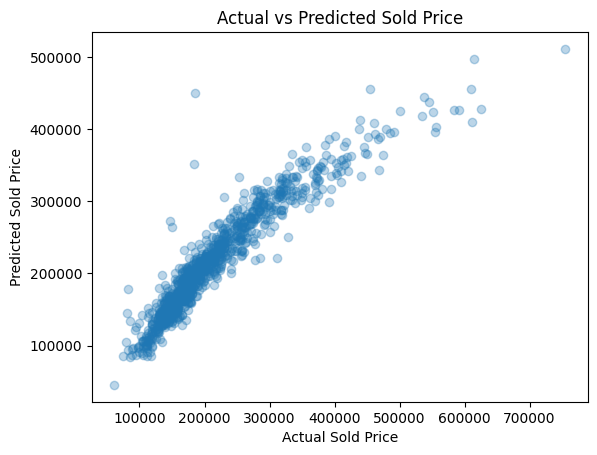

RMSLE: 0.12403706263458687
R2: 0.869527723607678
RMSE: 33284.77529417477


In [328]:
elasticnet_mlr = ElasticNet(alpha= 2.67).fit(X_train, Y_train)
Y_pred = elasticnet_mlr.predict(X_train)
plot_Yt_Yp(Y_train, Y_pred)
print_eval_metrics(Y_train, Y_pred)

We can observe that the RMSLE in ElasticNet (0.124) metric is similar to the one obtained in the the MLR (0.122). But we can see that R2 score on the train data has dropped from (MLR) 0.92 to (ElasticNet) 0.86. But this tradeoff is expected when trying to reduce the overfit. Considering that this model was already tuned with CV and a good result was obtained, we can expect a better generalization performance when testing with the unseen test dataset.

### 2.e. Commenting on the explanatory variables

In this section, we will comment on the explanatory variables by looking at the coefficients generated by both the MLR and ElasticNet models.

#### 2.e.1 Using basic MLR model

In [329]:
# Using the .coef_ attribute of the model to get the coefficients of the explanatory variables
print('Coefficients of explantory variables',basic_mlr.coef_[0])
# .coeff_ returns a 2D array, so we need to select the first element of the array which contains the coefficients

Coefficients of explantory variables [-4.68354532e+13 -9.95911730e+16  2.84447357e+03  3.19194530e+03
  1.84093717e+03 -3.01570194e+03  1.47015520e+03  3.41448476e+03
 -2.33511030e+02  1.70917291e+04  5.93824814e+03  9.69912203e+02
 -3.45011283e+03  4.51364014e+03 -2.43018557e+02 -7.63114922e+01
 -8.81647936e+02 -1.18341260e+03  3.92835897e+03 -3.12465677e+02
  6.23283800e+15  1.90665794e+03  1.96573574e+15  6.10749248e+15
 -5.65608038e+15  4.93128569e+02  9.25764071e+02  7.80776616e+16
  9.02545956e+16  1.52524492e+03  7.97636388e+02 -1.20007798e+03
  8.51167323e+02 -2.15100000e+03 -9.96406250e+02  7.70600000e+03
  1.26800000e+03  3.75300000e+03  4.97200000e+03 -2.66200000e+03
  4.10450000e+03  3.60000000e+02 -2.88000000e+02  6.09200000e+03
  6.96000000e+02  1.83400000e+03 -5.64000000e+02  1.60800000e+03
  6.16000000e+02  7.06000000e+02 -9.45000000e+01  3.12200000e+03
 -8.43500000e+02  3.95900000e+03  7.42000000e+02  3.52000000e+02
 -2.03800000e+03 -1.01000000e+03 -6.81255940e+15 -9.0

In [330]:
# create a dictionary of the coefficients and feature names
coef_dict1 = {}
for feat, coef in zip(X_names, basic_mlr.coef_[0][1:]): # skipping the first coefficient that corresponds to intercept
    coef_dict1[feat] = coef

# sort dictionary by the absolute value of the coefficient (magnitude)
coef_dict1 = sorted(coef_dict1.items(), key=lambda x: abs(x[1]), reverse=True)
print(coef_dict1)

[('BldgArea', -9.95911730444114e+16), ('X2FloorSF', 9.025459559385973e+16), ('X1FloorSF', 7.807766161653653e+16), ('MasVnrType_BrkFace', 2.4714021475833332e+16), ('MasVnrType_Stone', 2.386660009850087e+16), ('Condition2_Norm', 2.2754058631474452e+16), ('SaleCondition_Normal', -2.1590141198490156e+16), ('Exterior1st_VinylSd', -2.0947086773487456e+16), ('SaleCondition_Partial', -1.7928811850646292e+16), ('Exterior1st_HdBoard', -1.710626039322694e+16), ('Condition2_PosN', 1.612467921964309e+16), ('Exterior2nd_VinylSd', -1.5647533012470304e+16), ('SaleType_WD ', -1.4761786780317904e+16), ('Condition2_PosA', 1.3971977362617574e+16), ('Exterior1st_MetalSd', -1.3735182443348664e+16), ('SaleType_New', -1.301156636775968e+16), ('Exterior2nd_HdBoard', -1.2341268707035932e+16), ('Electrical_SBrkr', -1.2110722812397214e+16), ('SaleCondition_Abnorml', -1.1734871491846084e+16), ('Exterior1st_Wd Sdng', -1.1136238658510542e+16), ('Exterior1st_Plywood', -1.0914133903099602e+16), ('MSZoning_RL', 1.07780

We can see that the basic MLR model sets very high coefficients to the Variables. As per this model, `BldgArea`, `X2FloorSF` and `X1FloorSF` are the most important features, and have been given the highest coefficients.This follows what was analyzed in the pearson correlation with the target variable in the EDA.

#### 2.e.2 Using ElasticNet model

In [331]:
# where alpha is the optimal value of alpha found above
print('Coefficients of explanatory variables',elasticnet_mlr.coef_)

Coefficients of explanatory variables [    0.          6241.38857966  3241.95569359  2504.42887322
   231.99696237  -936.666419   -1028.80874531   599.08703736
   678.0310961   7059.88515725  1002.41035761  2128.84643652
  2053.98376249  5218.4466057   3198.03338133   170.23213282
  2586.36682473   -40.30004209  3710.59277485  2095.27521023
  4617.26468809  1132.58487095   933.16956399   -18.63846215
  5391.65159922  1797.34528345    65.05149833  5223.33269672
  2367.64554208  2761.88500754  -337.31019487  2519.73660876
  2011.76548208  1154.99983304  -824.67774639  5212.56541505
  4206.41815322  1004.62118114  3426.67723629  3129.27840343
  2162.64120916  1663.21852165  4022.40844978  4646.83661226
   186.80738023  -110.51412857  -204.96993591  2133.59972811
   437.30139174   278.55096538  -235.68833132  2207.07546121
    88.72707137  2687.89204388  -497.67910546 -2721.50286846
  -651.08001237  -213.45837206   292.04462312   105.75963748
   380.64697704  1391.26034529   115.13165445  

In [332]:
# create a dictionary of the coefficients and feature names
coef_dict2 = {}
for feat, coef in zip(X_names, elasticnet_mlr.coef_[1:]): # skipping the first coefficient that corresponds to intercept
    coef_dict2[feat] = coef
    
# sort dictionary by the absolute value of the coefficient (magnitude)
coef_dict2 = sorted(coef_dict2.items(), key=lambda x: abs(x[1]), reverse=True)
print(coef_dict2)

[('OverallQual', 7059.885157250567), ('BldgArea', 6241.388579659397), ('TotalBsmtSF', 5391.651599218554), ('X1FloorSF', 5223.332696719026), ('MasVnrArea', 5218.446605696034), ('KitchenQual', 5212.565415046286), ('Neighborhood_StoneBr', 4986.580277155378), ('GarageArea', 4646.836612264841), ('BsmtFinSF1', 4617.264688086146), ('Neighborhood_NridgHt', 4379.895018853271), ('TotRmsAbvGrd', 4206.418153221087), ('MiscFeature_Elev', -4140.601833819825), ('GarageCars', 4022.408449776146), ('BsmtExposure', 3710.5927748546133), ('Neighborhood_NoRidge', 3552.433397228771), ('Fireplaces', 3426.6772362859783), ('LotFrontage', 3241.9556935949263), ('ExterQual', 3198.033381330467), ('RoofMatl_WdShngl', 3148.4480528986574), ('FireplaceQu', 3129.2784034257147), ('BsmtFullBath', 2761.885007541484), ('MiscVal', -2721.502868460807), ('PoolQual', 2687.8920438842374), ('LandContour_Bnk', -2658.076217960781), ('BsmtQual', 2586.366824732989), ('FullBath', 2519.736608762087), ('LotArea', 2504.4288732212226), ('

We can see that the ElasticNet model sets smaller coefficients compared to the basic MLR model. As per this model, `OverallQual`, `BldgArea` and `TotalBsmtSF` are the most important features. This is because they have been given the highest coefficients. In our EDA, we had seen that the these features had high correlation with the target variable. Hence, it is not surprising that they are given high coefficients by the ElasticNet model.

#### 2.e.3 Comparing the coefficients of the two models
We now combine the coefficients from both models into a dataframe, and compare them side by side in a table and in a bar chart.

In [333]:
# Plotting top 10 variables from ElasticNet and comparing their coefficients in both models
elast_coeff = pd.DataFrame(coef_dict1, columns=['Variable', 'Coefficient_Basic'])
basic_coeff = pd.DataFrame(coef_dict2, columns=['Variable', 'Coefficient_ElasticNet'])

# Merge the counts based on the 'Neighborhood' column
combined = pd.merge(elast_coeff, basic_coeff, on='Variable', how='outer')

# sort the dataframe by the absolute value of the coefficient in the elastic net model
combined = combined.reindex(combined['Coefficient_ElasticNet'].abs().sort_values(ascending=False).index)
combined = combined.set_index('Variable')

combined.head(10)

,Coefficient_Basic,Coefficient_ElasticNet
Variable,,
OverallQual,1.709173e+04,7059.885157
BldgArea,-9.959117e+16,6241.388580
TotalBsmtSF,-5.656080e+15,5391.651599
X1FloorSF,7.807766e+16,5223.332697
MasVnrArea,4.513640e+03,5218.446606
KitchenQual,7.706000e+03,5212.565415
Neighborhood_StoneBr,1.293010e+15,4986.580277
GarageArea,6.092000e+03,4646.836612
BsmtFinSF1,6.232838e+15,4617.264688


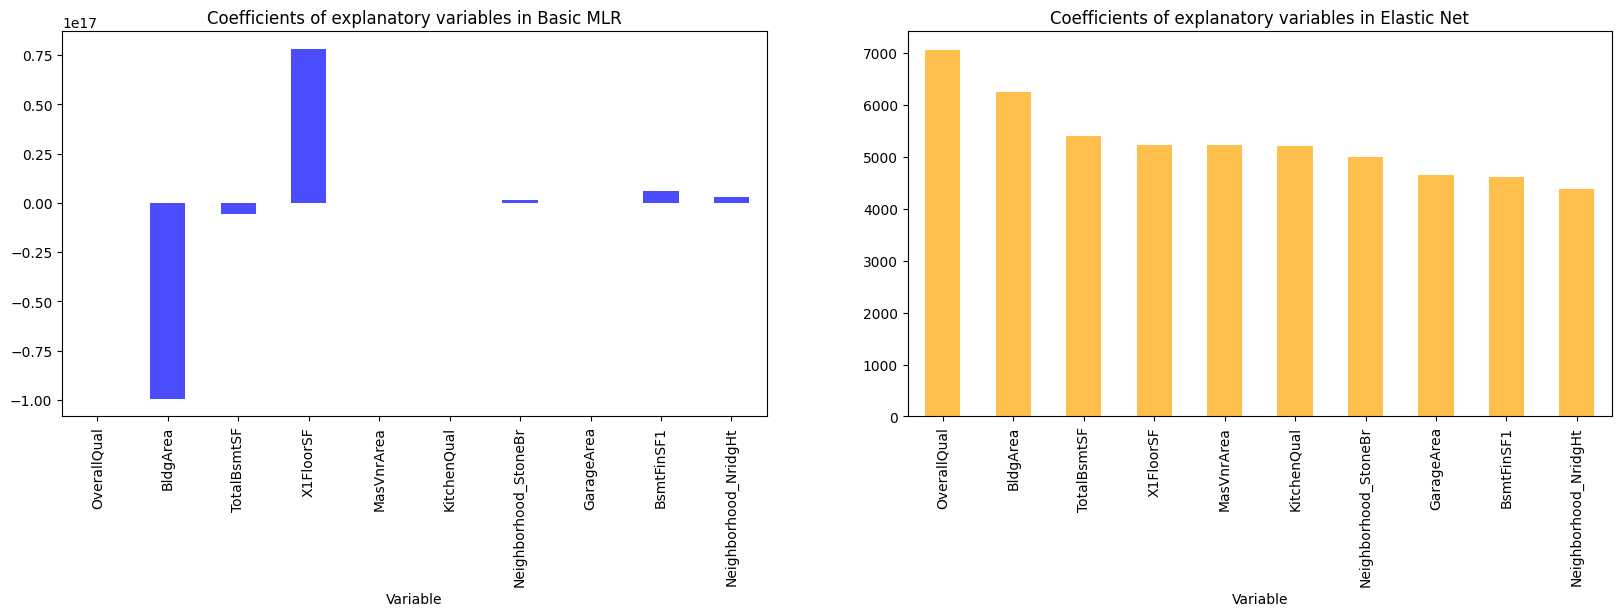

In [334]:
# Plotting as subplots because the scales are very different - some bar heights are visually nullified in dual bar chart 

fig, axes = plt.subplots(1,2, figsize=(20,5))
combined['Coefficient_Basic'].head(10).plot(kind='bar', alpha=0.7, ax=axes[0], color = 'blue')
combined['Coefficient_ElasticNet'].head(10).plot(kind='bar', alpha=0.7, ax=axes[1], color = 'orange' )
axes[0].set_title('Coefficients of explanatory variables in Basic MLR')
axes[1].set_title('Coefficients of explanatory variables in Elastic Net')
plt.show()

We can see that the coefficients from the ElasticNet model are much smaller than the coefficients from the basic MLR model. If we look at the chart on the left for coefficients from Basic MLR, we see that there are exponential differences among some of the coefficients (some bars are completely nullified!). However, in the ElasticNet model, the coeffiecients are more comparable among the variables. This is because the ElasticNet model has a regularisation term, which penalises the high coefficients.

## 3. Evaluation of the test performance of the models

In this section, we will evaluate the test performance of the both basic MLR and ElasticNet models. We will use the test dataset that we had created in the first section of this notebook.

### 5.a. Test performance of basic MLR model
We first apply the basic MLR model on the test dataset fitted previously (section 2.c). We then calculate the three evaluation metrics, namely, RMSE, R2 and RMSLE.

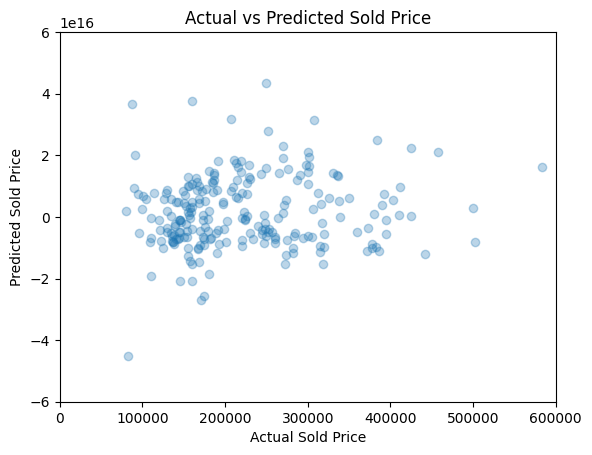

RMSLE: cannot be calculated
R2: -8.318860667658792e+22
RMSE: 2.6104883570526824e+16


In [335]:
# Apply the basic MLR model on the test data
Y_pred= basic_mlr.predict(X_test)
plot_Yt_Yp(Y_test, Y_pred, set_limit=(0, 600000, -60000000000000000, 60000000000000000))
print_eval_metrics(Y_test, Y_pred)


We can observe that the basic linear regression model performs poorly on the test dataset, with a negative R2 score and a high RMSE value. The RMSLE presents the same issue as in the **cross validation implementation** (section 2.c.2). We can clearly observe this bad performance in the graph and also notice the prediction of negative values.

There are two interesting elements to observe from these results:
1. The model is predicting negative values, when the ground truth target value has only positive values (and not even values close to zero). Moreover the scale of the predcited values is totally different from the scale of true values
2. The model presents a really good performance when testing on the same training data, but a really bad performance when testing on unseen data.

While this only concludes that the model fitted for Multiple Linear Regression is too complex, and overfitting for the training data, with a poor ability of generalization on unseen data - we would like to reiterate that we were already able to make these conclusions from cross validation fairly accurately.

### 5.b. Test performance of ElasticNet model
We now apply the ElasticNet model on the test dataset tuned previously (section 2.d). We then calculate the three evaluation metrics, namely, RMSE, R2 and RMSLE.

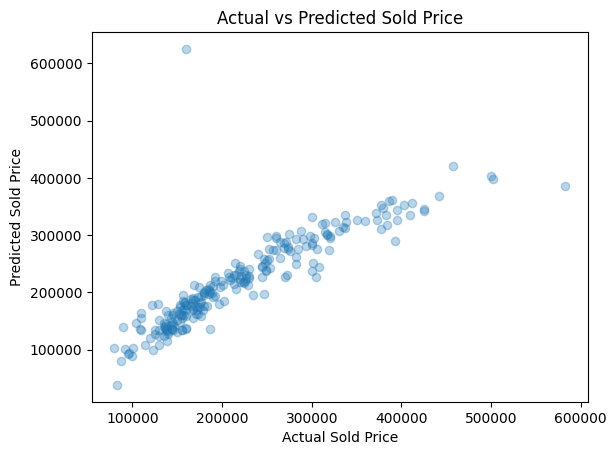

RMSLE: 0.16236722580427698
R2: 0.7657033201006015
RMSE: 43809.964636868935


In [336]:
# Evaluate test performance
Y_pred = elasticnet_mlr.predict(X_test)
plot_Yt_Yp(Y_test, Y_pred)
print_eval_metrics(Y_test, Y_pred)

We see that the RMSLE is 0.16,  is achieved on the test data which is a good score (i.e. closer to zero). This is a significant improvement from the basic MLR that we fitted earlier and a considerably good score. The other metrics also indicate a good performance, with an R2 of 0.75 and an RMSE that is in a reasonable scale considering the scale of the target variable. 

### 5.c. Configuration of the best model

After analyzing the performance of the two developed models, we can conclude that the **configuration** of the best model is the ElasticNet model with alpha = 2.67. This model has an RMSLE score of 0.16, R2 of 0.76 and an RMSE of 43809.96 on the test data.



### References
"Applied Machine Learning" [Web page]. (n.d.). Andreas C. Müller. https://amueller.github.io/aml/index.html

"Cross-Validation with Linear Regression" [Web log post]. (n.d.). Kaggle. https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression

"Good Train-Test Split: An Approach to Better Accuracy" [Web log post]. (2019, October 22). Medium. https://code.likeagirl.io/good-train-test-split-an-approach-to-better-accuracy-91427584b614

"Root Mean Squared Error (RMSE) vs. RMSLE" [Web log post]. (n.d.). Analytics Vidhya. https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

"Root Mean Squared Logarithmic Error (RMSLE)" [Web page]. (n.d.). Pecan AI Help Center. https://help.pecan.ai/en/articles/6456388-model-performance-metrics-for-regression-models#Modelperformancemetricsforregressionmodels-RootMeanSquaredLogarithmicError(RMSLE)

Shadab, M. (n.d.). "Root Mean Squared Error (RMSE) & Root Mean Squared Logarithmic Error." Medium. https://techwithshadab.medium.com/root-mean-squared-error-root-mean-squared-logarithmic-error-70e645efcccb